#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Импорт библиотек

In [1]:
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

import scipy.stats as stats

import time

import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Подготовка

In [3]:
data = pd.read_csv('taxi.csv', index_col='datetime', parse_dates=True)

In [4]:
data.index.is_monotonic # проверка расположения данных в хронологическом порядке

True

Проведем ресемплирование с заданным интервалом в 1 час.

In [5]:
data = data.resample('1H').sum()

И посмотрим что получилось.

In [6]:
print(data.info())
display(data.describe().transpose())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные в порядке, ресемплирование проведено успешно.

# Анализ

Посмотрим на данные в разбивке на тренд, сезонность и остатки.

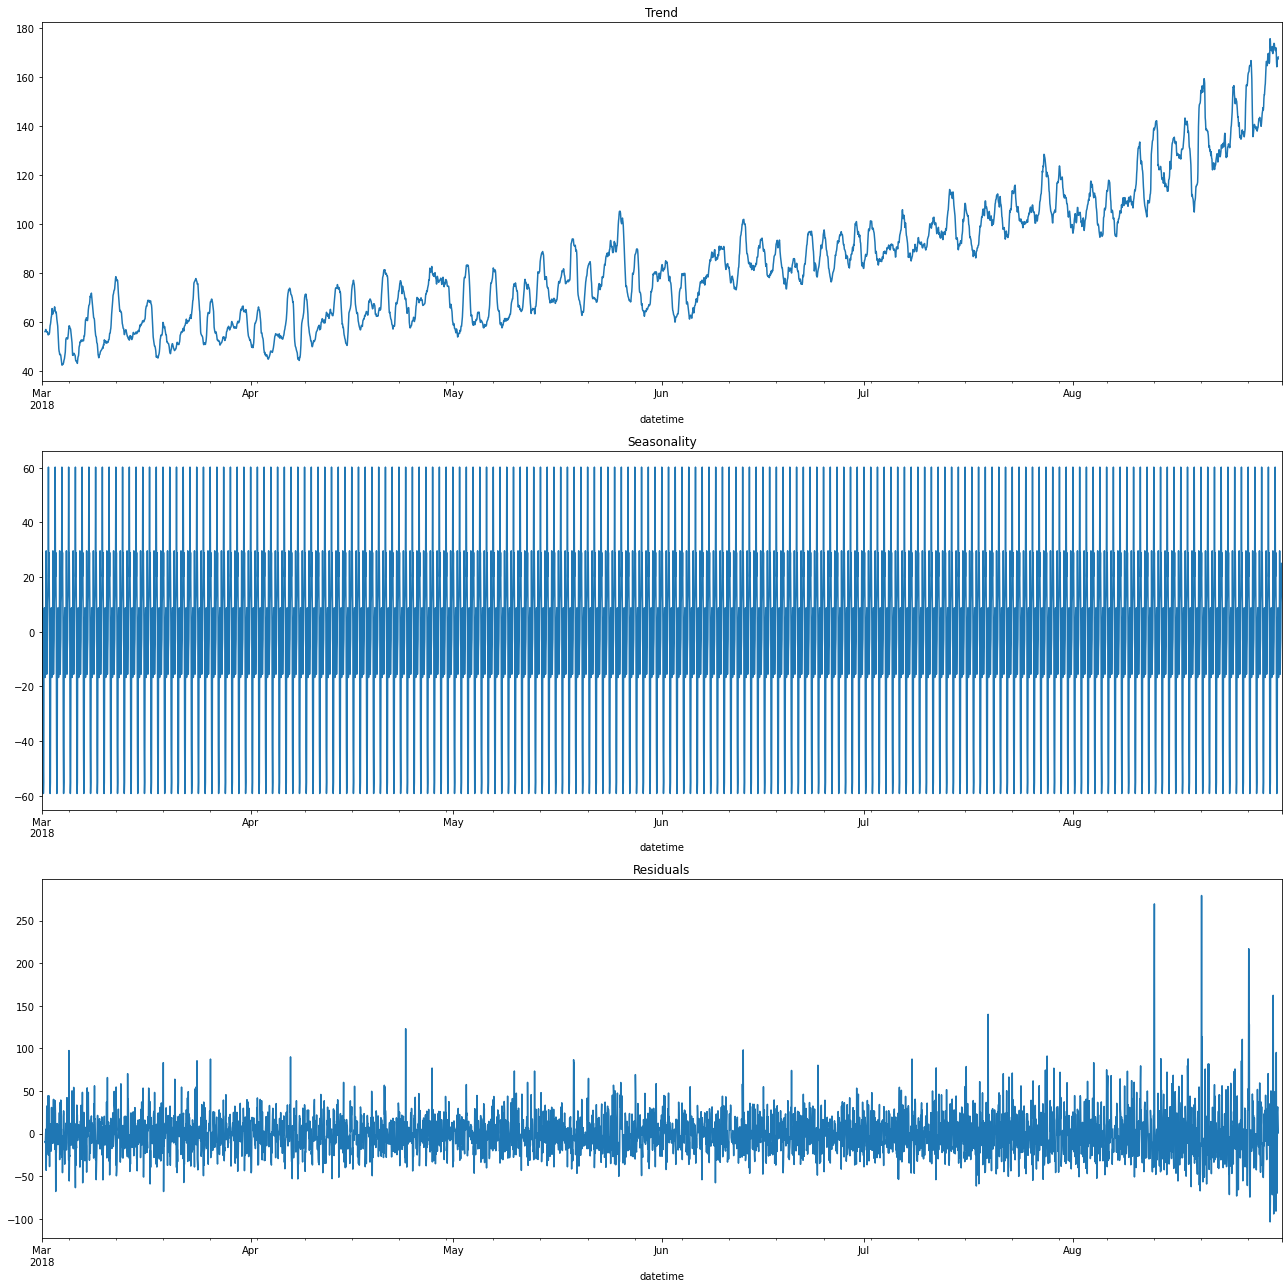

In [7]:
decomposed = seasonal_decompose(data, period=24)

plt.figure(figsize=(18, 18))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

И видно, что за эти 6 месяцев наблюдается тренд к росту количества клиентов.

Посмотрим на график сезонности при большем увеличении.

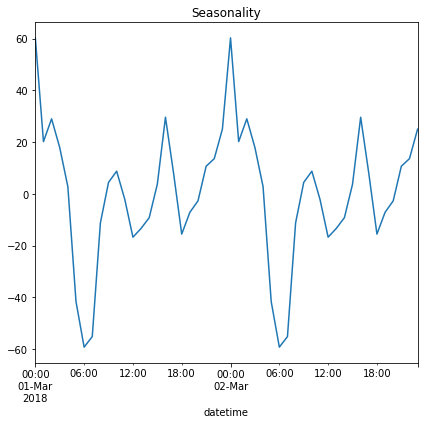

In [8]:
decomposed.seasonal['2018-03-01' : '2018-03-02'].plot(figsize=(6, 6))
plt.title('Seasonality')
plt.tight_layout()

Из графика сезонности видно, что наименьшее количество клиентов как правило приходится на раннее утро (06:00), а наибольшее на полночь.

Проведем аналогичный осмотр для недельной сезонности.

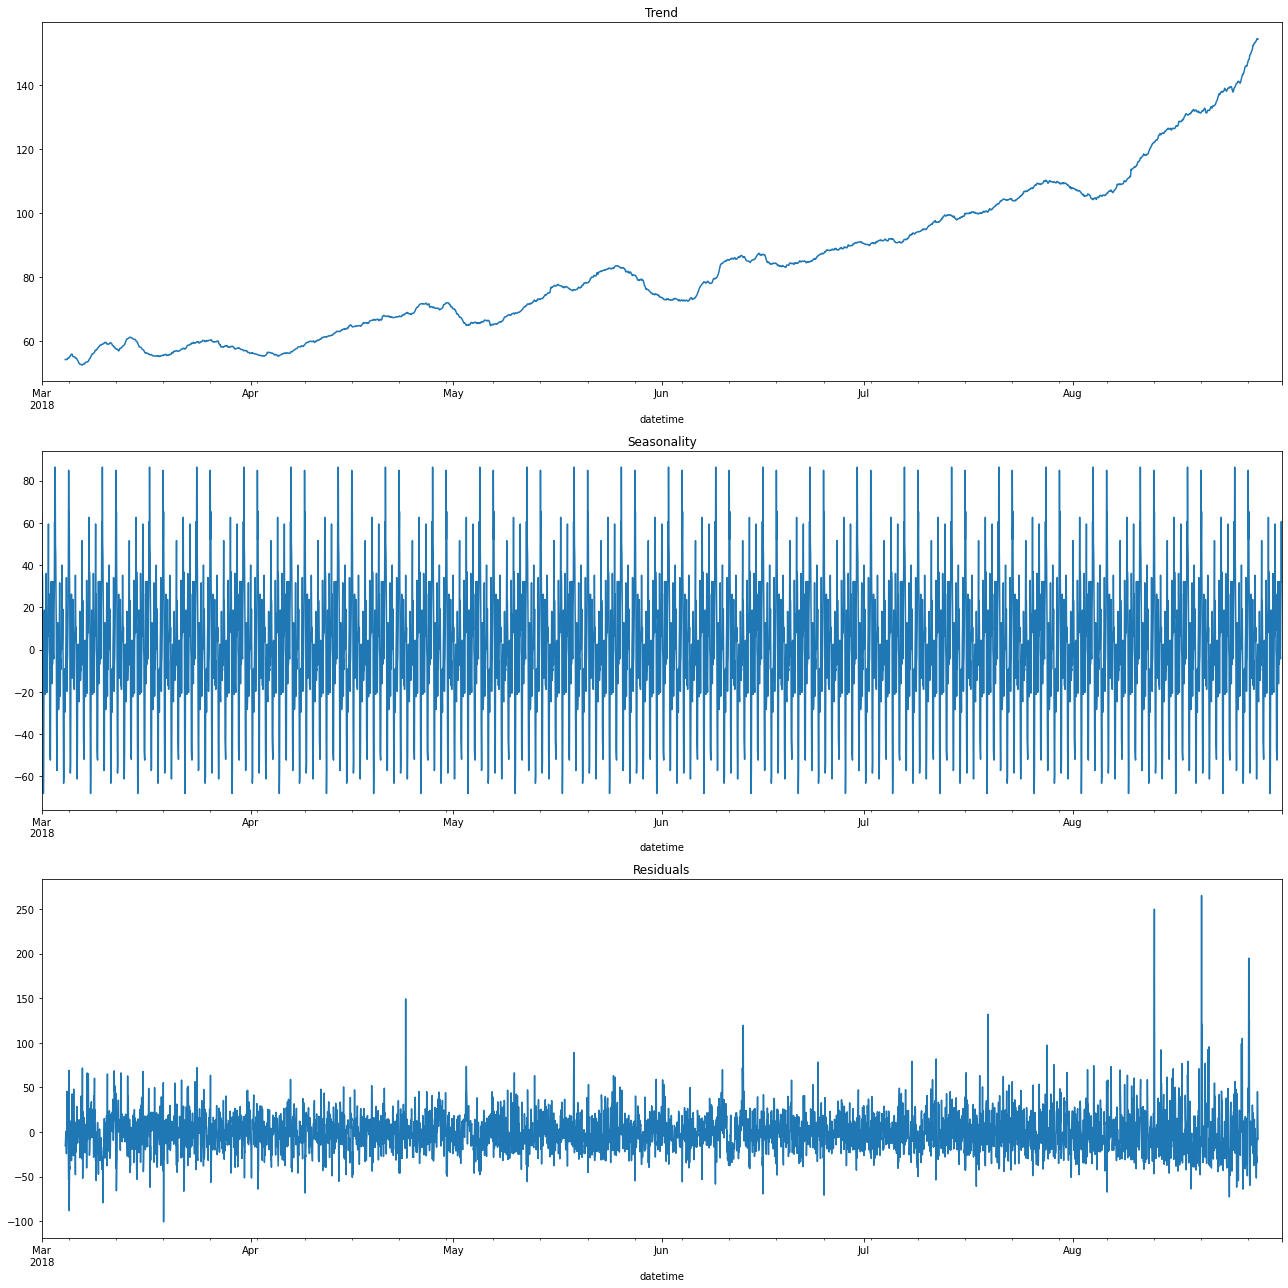

In [9]:
decomposed = seasonal_decompose(data, period=168)

plt.figure(figsize=(18, 18))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

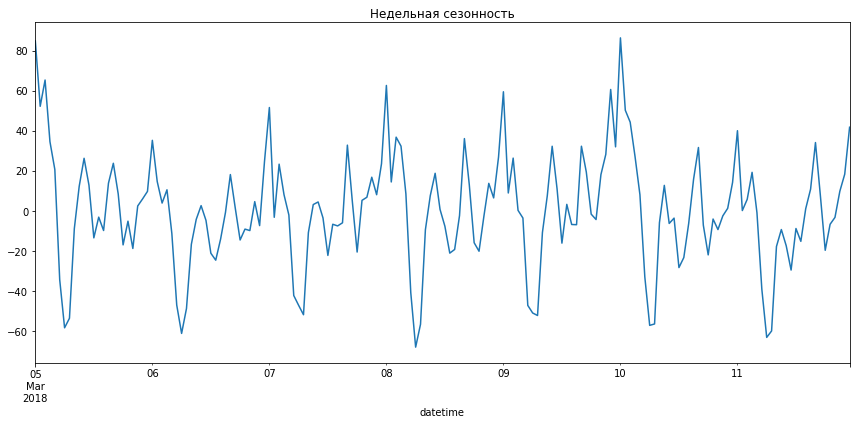

In [10]:
decomposed.seasonal['2018-03-05' : '2018-03-11'].plot(figsize=(12, 6))
plt.title('Недельная сезонность')
plt.tight_layout()

В недельной сезонности видно, что наибольшее число клиентов как правило приходится на ночь с пятницы на субботу и с воскресенья на понедельник.

# Генерация фич

Фичами у нас будут: день недели, час, отстающие значения временного ряда и скользящее среднее.

Для выбора оптимального способа генерации фич применим процесс похожий на GridSearchCV. Сначала напишем функцию - генератор фич.

In [11]:
def make_features(data, max_lag=1, rolling_mean_size=2):
    features = data.copy()
    # features['month'] = features.index.month
    # features['day'] = features.index.day
    features['dayofweek'] = features.index.dayofweek
    features['hour'] = features.index.hour
    total = [features]
    
    for lag in range(1, max_lag + 1):
        total.append(pd.Series(features['num_orders'].shift(lag),
                               index=features.index,
                               name='lag_{}'.format(lag)
                              )
                    )

    total.append(pd.Series(features['num_orders'].rolling(rolling_mean_size).mean().shift(1),
                          index=features.index,
                          name='rolling_mean')
                )
    
    return pd.concat(total, axis=1) 
# Объединение сгенерированних столбцов одним конечным шагом увеличивает быстродействие 
# в сравнении с записью каждого столбца в основной датафрейм сразу.

Теперь проведем анализ оптимального количества сгенерированных фич с помощью пробного предсказания самой быстрой из моделей - LinearRegression.

In [12]:
def feature_optimizer(data, mean_range, lag_range):
    result = {}
    for mean in mean_range:
        mean_train_scores = []   # В данные списки будут записаны средние RMSE моделей для данной ширины 
        mean_test_scores = []    # скользящего среднего для данного количества отстающих значений временного ряда
        is_better = False        # это необходимо для дальнейшей постройки кривых валидации

        for lag in lag_range:
            features = make_features(data, lag, mean)
            features = features.dropna()
            X = features.drop('num_orders', axis=1)
            y = features.num_orders

            linear_cross = cross_validate(LinearRegression(),
                                          X,
                                          y,
                                          scoring='neg_root_mean_squared_error',
                                          return_train_score=True, 
                                          cv=TimeSeriesSplit())
            mean_train = linear_cross['train_score'].mean()
            mean_test = linear_cross['test_score'][1:].mean()   # Первый элемент может выдавать аномально низкие значения RMSE
            mean_train_scores.append(mean_train)                # Поэтому для адекватности оценки его лучше не учитывать
            mean_test_scores.append(mean_test)

            if mean == mean_range[0] and lag == lag_range[0]:
                best_test_score = mean_test
            elif best_test_score < mean_test:
                best_test_score = mean_test
                result['best_test_score'] = best_test_score
                result['best_lag'] = lag
                result['best_rolling_mean'] = mean
                is_better = True

        if is_better:
            result['best_mean_train_scores'] = mean_train_scores.copy()
            result['best_mean_test_scores'] = mean_test_scores.copy()
    return result

In [13]:
train_features, test_features = train_test_split(data, shuffle=False, test_size=0.1)

In [14]:
results = feature_optimizer(train_features, range(2, 51, 2), range(10, 401, 10))

Посмотрим на полученные кривые валидации.

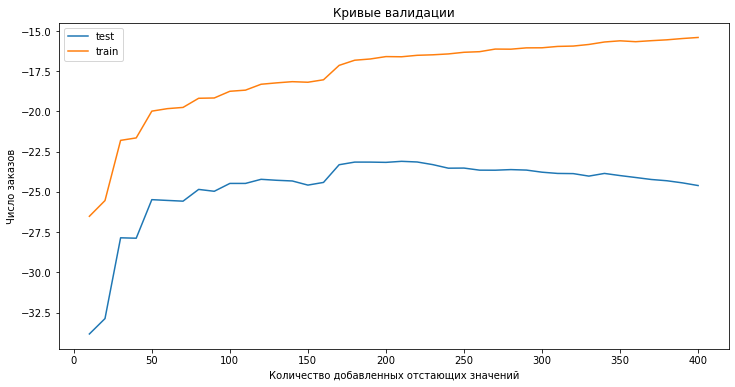

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(range(10, 401, 10), results['best_mean_test_scores'], label='test')
plt.plot(range(10, 401, 10), results['best_mean_train_scores'], label='train')
plt.legend()
plt.title('Кривые валидации')
plt.ylabel('Число заказов')
plt.xlabel('Количество добавленных отстающих значений')
plt.show()

In [16]:
print(f'Лушие значения достигаются при ширине рамки скользящего среднего = {results["best_rolling_mean"]}')

Лушие значения достигаются при ширине рамки скользящего среднего = 2


In [17]:
print(f"""Лучшая метрика RMSE для тестовой выборки внутри кросс-валидации равна {results['best_test_score']} и достигается при:
количестве отстающих = {results['best_lag']};
ширине рамки скользящего среднего = {results['best_rolling_mean']}.""")

Лучшая метрика RMSE для тестовой выборки внутри кросс-валидации равна -23.102073633516838 и достигается при:
количестве отстающих = 210;
ширине рамки скользящего среднего = 2.


Видно, что с ростом количества добавленных отстающих значений растет переобученность модели. На участке 200 - 220 достигается макимум качества предсказания для тестовой выборки.

Более детально рассмотрим участок от 200 до 220, при ширине скользящего среднего 2.

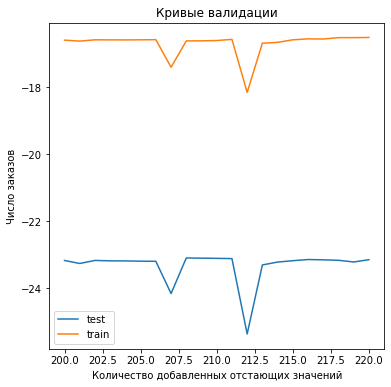

In [18]:
results = feature_optimizer(train_features, range(2, 3), range(200, 221))
plt.figure(figsize=(6, 6))
plt.plot(range(200, 221), results['best_mean_test_scores'], label='test')
plt.plot(range(200, 221), results['best_mean_train_scores'], label='train')
plt.legend()
plt.title('Кривые валидации')
plt.ylabel('Число заказов')
plt.xlabel('Количество добавленных отстающих значений')
plt.show()

In [19]:
print(f"""Лучшая метрика RMSE для тестовой выборки внутри кросс-валидации равна {results['best_test_score']} и достигается при:
количестве отстающих = {results['best_lag']};
ширине рамки скользящего среднего = {results['best_rolling_mean']}.""")

Лучшая метрика RMSE для тестовой выборки внутри кросс-валидации равна -23.090832756951727 и достигается при:
количестве отстающих = 208;
ширине рамки скользящего среднего = 2.


Применим полученную информацию для обучения моделей.

# Обучение

In [20]:
data_model = make_features(data, results['best_lag'], results['best_rolling_mean'])
data_model = data_model.dropna()
train, test = train_test_split(data_model, test_size=0.1, shuffle=False)

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [21]:
models_params = {
    LinearRegression() : dict(),
    ElasticNet(random_state=24) : dict(alpha=stats.uniform(0, 1), l1_ratio=stats.uniform(0, 1)),
    DecisionTreeRegressor(random_state=24) : dict(max_depth=range(1, 101), min_samples_split=stats.loguniform(1e-5, 1e-2)),
    LGBMRegressor(random_state=24) : dict(max_depth=range(-1, 201), num_leaves=range(5, 101), n_estimators=range(1, 201)),
    DummyRegressor() : dict(strategy=['median'])
}

In [22]:
trained_models=[]
for model, params in models_params.items():
    timer = time.time()
    random_search = RandomizedSearchCV(model, param_distributions=params, scoring='neg_root_mean_squared_error', random_state=24, n_iter=100, cv=TimeSeriesSplit())
    random_search.fit(X_train, y_train)
    timer = time.time() - timer
    print(f'Обучение модели {model} заняло {timer:.2f} сек или {(timer / 60):.2f} мин')
    trained_models.append(random_search)

Обучение модели LinearRegression() заняло 0.23 сек или 0.00 мин
Обучение модели ElasticNet(random_state=24) заняло 204.61 сек или 3.41 мин
Обучение модели DecisionTreeRegressor(random_state=24) заняло 120.39 сек или 2.01 мин
Обучение модели LGBMRegressor(random_state=24) заняло 286.17 сек или 4.77 мин
Обучение модели DummyRegressor() заняло 0.02 сек или 0.00 мин


# Тестирование

In [23]:
def model_scoring(model, X_test, y_test): # функция для выведения оценки модели.
    print('Модель', model.best_estimator_)
    print('Лучший RMSE при кросс-валидации =', -model.best_score_)
    predicted = model.predict(X_test)
    print(f'RMSE на тестовой выборке = {mean_squared_error(y_test, predicted, squared=False)}')
    
    plt.figure(figsize=(18,6))
    y_test['2018-08-14' : '2018-08-20'].plot(label='Реальные')
    predicted = pd.Series(predicted, index=y_test.index)
    predicted['2018-08-14' : '2018-08-20'].plot(label='Предсказываемые')
    plt.title('Результаты модели, неделя')
    plt.xlabel('Дата')
    plt.ylabel('Число заказов')
    plt.legend()
    plt.show()

    return None

Модель LinearRegression()
Лучший RMSE при кросс-валидации = 23.04671980490533
RMSE на тестовой выборке = 34.35669821988874


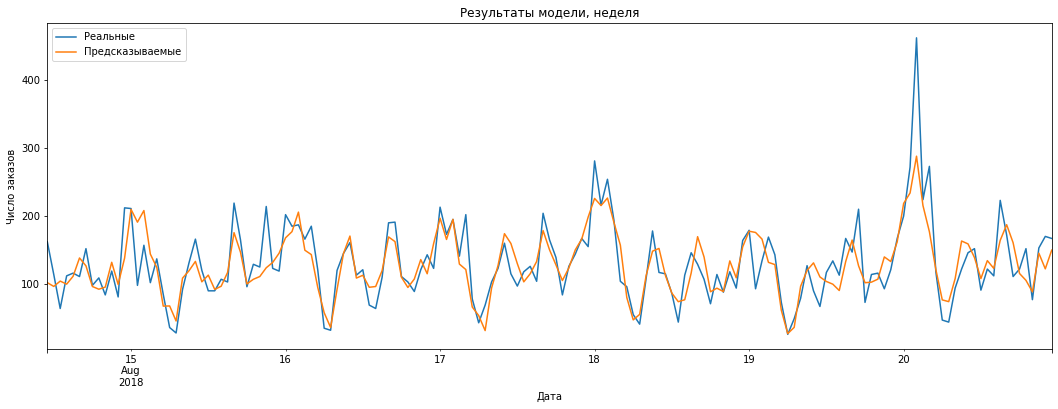

In [24]:
model_scoring(trained_models[0], X_test, y_test)

Модель ElasticNet(alpha=0.9299161456275704, l1_ratio=0.9421376901338476,
           random_state=24)
Лучший RMSE при кросс-валидации = 22.835386701814667
RMSE на тестовой выборке = 34.37462581408434


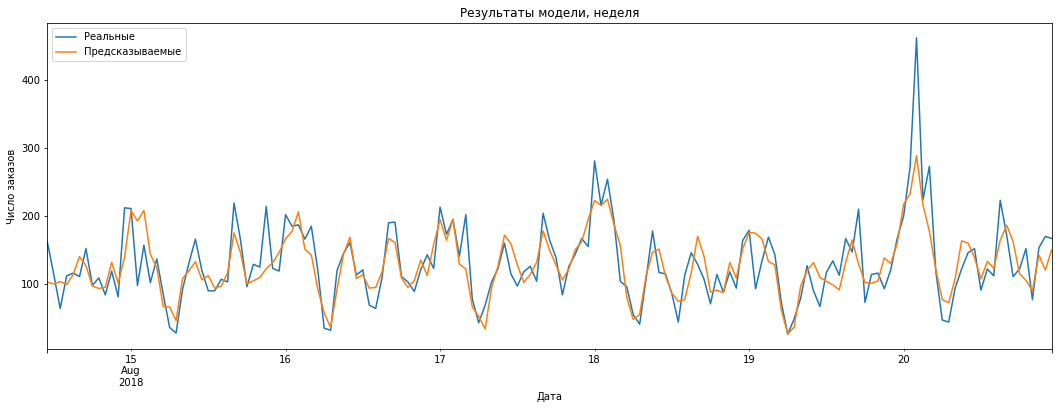

In [25]:
model_scoring(trained_models[1], X_test, y_test)

Модель DecisionTreeRegressor(max_depth=4, min_samples_split=0.0008446493334353485,
                      random_state=24)
Лучший RMSE при кросс-валидации = 27.551703757132003
RMSE на тестовой выборке = 53.04387829517657


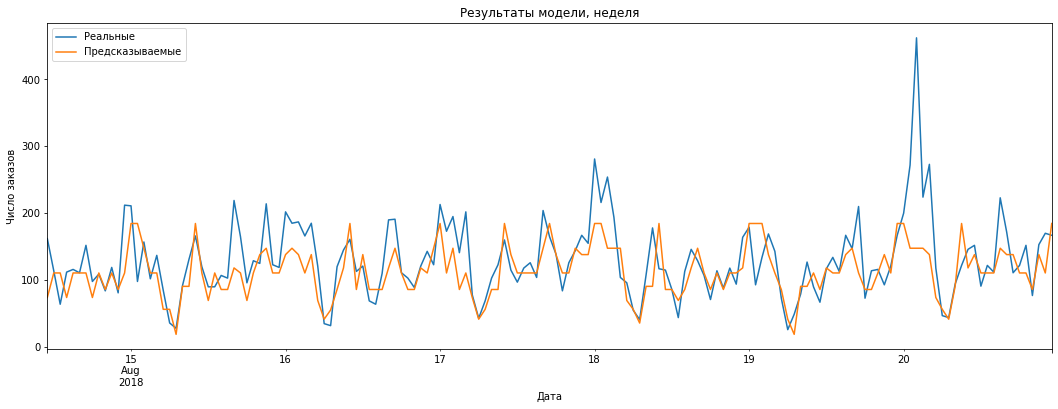

In [26]:
model_scoring(trained_models[2], X_test, y_test)

Модель LGBMRegressor(max_depth=64, n_estimators=123, num_leaves=5, random_state=24)
Лучший RMSE при кросс-валидации = 22.621608343590296
RMSE на тестовой выборке = 36.682783207107406


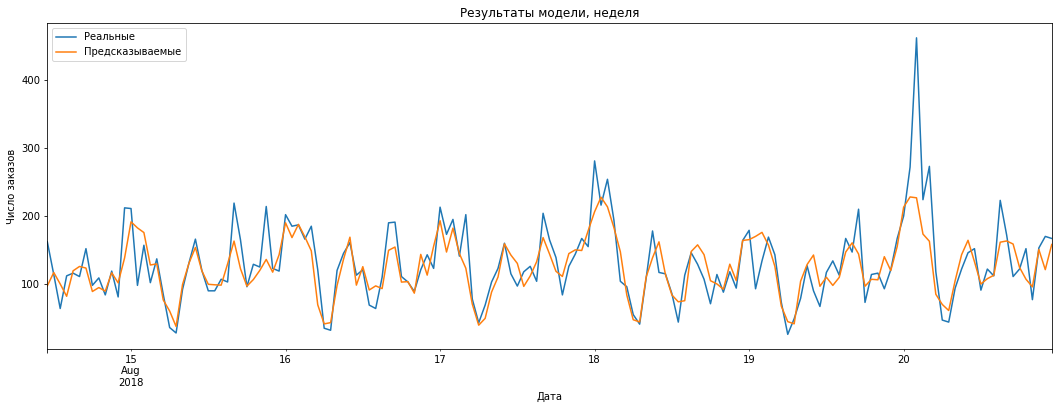

In [27]:
model_scoring(trained_models[3], X_test, y_test)

Модель DummyRegressor(strategy='median')
Лучший RMSE при кросс-валидации = 41.898390636911714
RMSE на тестовой выборке = 87.30988848394198


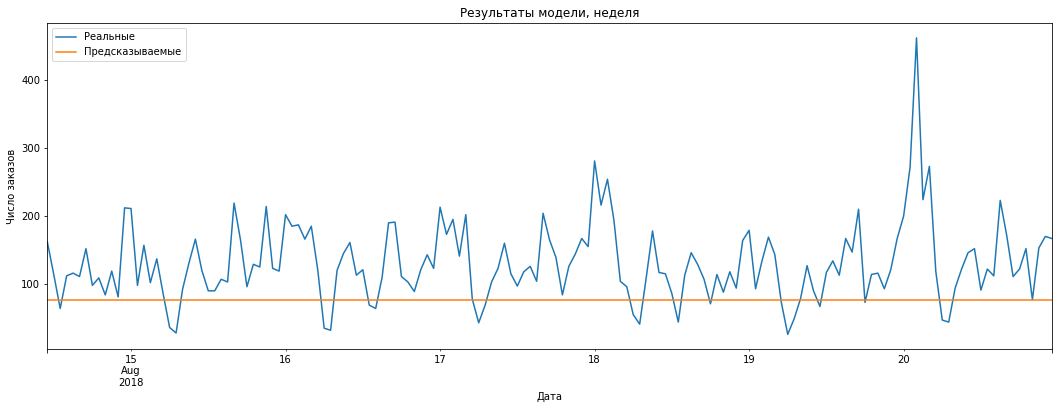

In [28]:
model_scoring(trained_models[4], X_test, y_test)

Все модели справились успешнее чем дамми модель и прошли проверку на адекватность.

Вывод: Лучшую метрику RMSE равную 34.35 дала простая линейная модель. Возможно это связано с тем, что подбор количества генерируемых фич проходил с проверкой качества через линейную регрессию.